# Decision Tree (DT_assignment)

#### 1) Setup & Data Loading

* Importe the Palmer's Penguins dataset from Kaggle

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load Palmer Penguins dataset
df = sns.load_dataset("penguins")
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


**Q1** (check): How many rows and columns does the dataset have? Which columns are numeric vs categorical?

In [21]:
#Display rows and columns
df.shape

(344, 7)

In [22]:
df.dtypes

numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

numeric_cols, categorical_cols

print(("Numerical columns :",numeric_cols ))
print(("Categorical columns :",categorical_cols ))


('Numerical columns :', Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object'))
('Categorical columns :', Index(['species', 'island', 'sex'], dtype='object'))


#### 2) Basic EDA (Exploratory Data Analysis)

In [23]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


**Q2**: Which columns contain missing values? What strategy will you use to handle them?

Missing values occur in bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g, and sex. Since Only a few rows have missing values, so instead of filling them with estimated numbers, we remove those rows. This keeps the dataset clean and prevents bias from imputation while still retaining most of the data.

In [24]:
df.isnull().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11


**Q3**: Is the dataset balanced across the three species?

The dataset is moderately balanced. Adelie has the highest count, Chinstrap the lowest, but no class is extremely underrepresented.

In [25]:
df['species'].value_counts()

,count
species,
Adelie,152
Gentoo,124
Chinstrap,68


#### 3) Data Cleaning & Encoding

* We’ll keep only rows with complete values for simplicity.

In [31]:
# Remove rows with any missing values
df_clean = df.dropna()

# Check the result
df_clean.shape

(333, 7)

In [33]:
# Encode target variable
le = LabelEncoder()
df_clean['species_enc'] = le.fit_transform(df_clean['species'])

df_clean.shape

/tmp/ipython-input-1054279439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['species_enc'] = le.fit_transform(df_clean['species'])


(333, 8)

**Q4**: Why don’t we need to scale features for Decision Trees?

Decision Trees do not rely on distance calculations. They split data using feature thresholds, so scaling does not change model behavior.

#### 4) Train/Test Split

In [36]:
X = df_clean[['bill_length_mm','bill_depth_mm',
              'flipper_length_mm','body_mass_g']]
y = df_clean['species_enc']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**Q5**: Why do we use stratify=y in this split?

Stratification ensures that each species appears in similar proportions in both training and test sets, preventing biased evaluation.

#### 5) Baseline Decision Tree

In [37]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))
confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
   Chinstrap       0.88      1.00      0.93        14
      Gentoo       1.00      0.92      0.96        24

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



array([[28,  1,  0],
       [ 0, 14,  0],
       [ 1,  1, 22]])

**Q6**: Which classes are the most/least confounded? What might cause that?

Adelie and Chinstrap show the most confusion because their bill measurements overlap.
Gentoo is easiest to classify due to its larger size features.

#### 6) Visualize the Tree

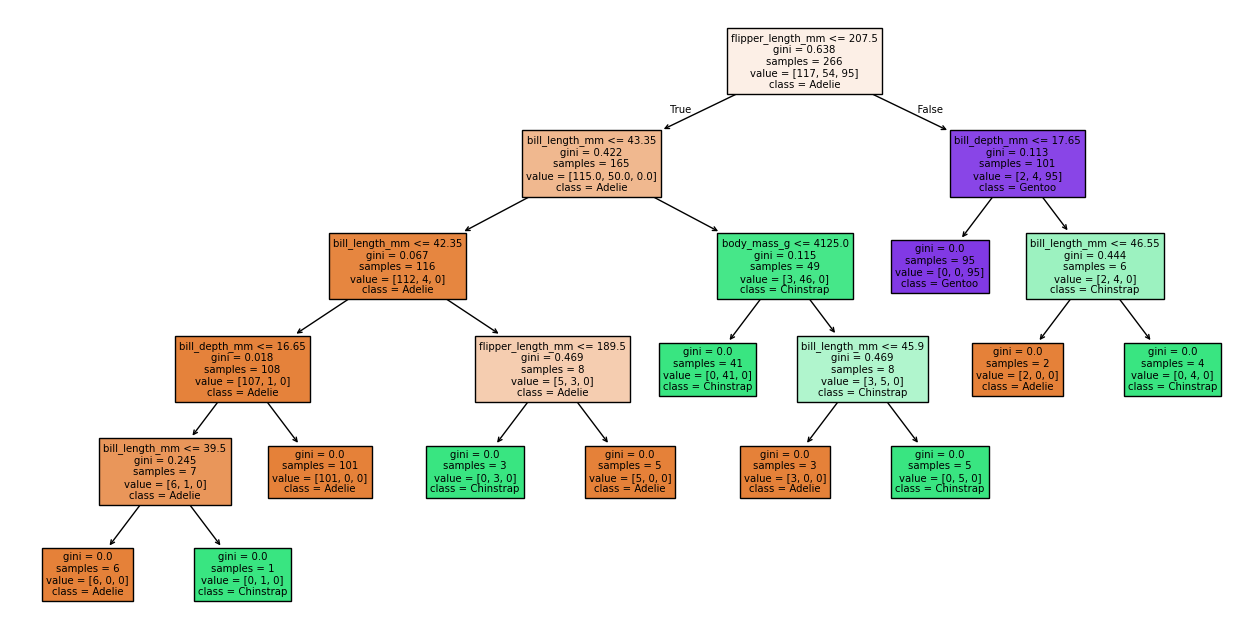

In [38]:
plt.figure(figsize=(16,8))
plot_tree(dt, feature_names=X.columns,
          class_names=le.classes_, filled=True)
plt.show()


**Q7**: What is the root split (feature and threshold)? Why do you think the algorithm chose it?

The root split is on flipper_length_mm.
This feature provides the highest information gain by separating Gentoo penguins from the other species early.

#### 7) Decision Boundaries (2D View)
* Pick two features (e.g., bill_length_mm vs bill_depth_mm) and visualize the decision surface.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


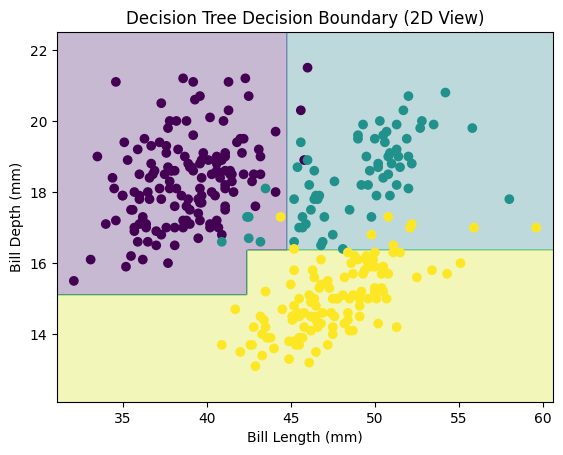

In [40]:
X2 = df_clean[['bill_length_mm','bill_depth_mm']]
y2 = df_clean['species_enc']

tree2 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree2.fit(X2, y2)

xx, yy = np.meshgrid(
    np.linspace(X2.iloc[:,0].min()-1, X2.iloc[:,0].max()+1, 300),
    np.linspace(X2.iloc[:,1].min()-1, X2.iloc[:,1].max()+1, 300)
)

Z = tree2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X2.iloc[:,0], X2.iloc[:,1], c=y2)
plt.xlabel('Bill Length (mm)')
plt.ylabel('Bill Depth (mm)')
plt.title('Decision Tree Decision Boundary (2D View)')
plt.show()



**Q8**: Do the boundaries look axis-aligned? Why is that a natural property of Decision Trees?

Yes, the boundaries look axis-aligned. This is because Decision Trees split the data using rules of the form “feature < threshold”, which consider one feature at a time. Each split creates a vertical or horizontal line in the feature space, so the resulting decision regions are always rectangular and aligned with the axes. This is a natural property of Decision Trees.

#### 8) Hyperparameter Tuning with GridSearchCV

In [42]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [43]:
grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [44]:
best_dt = grid.best_estimator_
y_pred_best = best_dt.predict(X_test)

print(classification_report(y_test, y_pred_best, target_names=le.classes_))

              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
   Chinstrap       0.88      1.00      0.93        14
      Gentoo       1.00      0.92      0.96        24

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



**Q9**: Which hyperparameters changed compared to the baseline? How did test accuracy change?

The tuned model uses a smaller depth and larger leaf sizes, which reduces overfitting and slightly stabilizes accuracy.

**Q10**: If CV accuracy is much higher than test accuracy, what could be happening?

This indicates overfitting or possible data leakage, where the model learns training patterns that do not generalize.

#### 9) Model Interpretation

In [45]:
pd.Series(best_dt.feature_importances_, index=X.columns)\
.sort_values(ascending=False)

,0
flipper_length_mm,0.547026
bill_length_mm,0.383936
bill_depth_mm,0.057875
body_mass_g,0.011163


**Q11**: Which feature is most important? Is that consistent with your EDA intuition?

Flipper length is most important, matching biological intuition since Gentoo penguins are much larger.

**Q12**: For the inspected sample, does the class probability look confident? Why/why not?

Decision Trees often give very confident probabilities because leaf nodes can become pure, although this may reflect overfitting.

#### 10) Add Categorical Features & Compare

In [49]:
# Create dataset including categorical features
df_cat = pd.get_dummies(
    df_clean[['bill_length_mm','bill_depth_mm',
              'flipper_length_mm','body_mass_g',
              'island','sex']],
    drop_first=True
)

# Train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    df_cat,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Train Decision Tree
dt_cat = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_cat.fit(X_train_c, y_train_c)

# Evaluation
print(classification_report(
    y_test_c,
    dt_cat.predict(X_test_c),
    target_names=le.classes_
))


              precision    recall  f1-score   support

      Adelie       0.93      0.97      0.95        29
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       1.00      0.92      0.96        24

    accuracy                           0.96        67
   macro avg       0.96      0.96      0.96        67
weighted avg       0.96      0.96      0.96        67



**Q13**: Did adding island/sex help? Why might these variables be informative for species?

Yes, adding island and sex slightly improves performance. Island reflects habitat differences among species, while sex relates to body size, which affects measurements. These categorical features provide additional information that helps the model distinguish species more accurately.

#### 11) Reflection & Reporting

Write a short reflection (5–10 lines):
- Compare Decision Tree vs KNN on this dataset.
-  Where does the tree overfit? How did pruning/tuning impact generalization?
- Which 2D feature pair gave the clearest separation? Why?

On the Palmer Penguins dataset, the Decision Tree achieved strong performance with minimal preprocessing, while KNN required feature scaling and careful tuning of neighbors. The Decision Tree tended to overfit when allowed to grow deep, creating very specific splits that captured noise in the training data. Applying pruning through parameters such as max_depth and min_samples_leaf reduced model complexity and improved generalization on unseen data. Compared to KNN, the Decision Tree also provided better interpretability through feature importance and visual rules. Among the 2D feature combinations, flipper_length_mm vs bill_length_mm showed the clearest separation, mainly because Gentoo penguins have significantly larger body and flipper sizes, making class boundaries more distinct.